In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import time
import musical_mdn
import sketch_mixture

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


<module 'sketch_mixture' from 'sketch_mixture.pyc'>

In [101]:
NET_MODE_TRAIN = 'train'
NET_MODE_RUN = 'run'
MODEL_DIR = "/Users/charles/src/mdn-experiments/"
LOG_PATH = "/tmp/tensorflow/"

class MixtureRNN(object):
    def __init__(self, mode = NET_MODE_TRAIN, n_hidden_units = 128, n_mixtures = 24, batch_size = 100, sequence_length = 120):
        """Initialise the TinyJamNet model. Use mode='run' for evaluation graph and mode='train' for training graph."""
        # hyperparameters
        self.mode = mode
        self.n_hidden_units = n_hidden_units
        self.n_rnn_layers = 3
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.st_dev = 0.5 
        self.n_mixtures = n_mixtures # number of mixtures
        self.n_input_units = 2 # Number of dimensions of the input (and sampled output) data
        self.mdn_splits = 6 # (pi, sigma_1, sigma_2, mu_1, mu_2) # forget about (rho) for now.
        self.n_output_units = n_mixtures * self.mdn_splits # KMIX * self.mdn_splits
        self.lr = 1e-4 # could be 1e-3
        self.lr_decay_rate = 0.9999,  # Learning rate decay per minibatch.
        self.lr_minimum = 0.00001,  # Minimum learning rate.
        self.grad_clip=1.0
        self.state = None
        self.use_input_dropout = False
        if self.mode is NET_MODE_TRAIN:
            self.use_input_dropout = True
        self.dropout_prob = 0.90

        tf.reset_default_graph()
        self.graph = tf.get_default_graph()
        
        with self.graph.as_default():
            with tf.name_scope('input'):
                self.x = tf.placeholder(dtype=tf.float32, shape=[self.batch_size,self.sequence_length,self.n_input_units], name="x") # input
                self.y = tf.placeholder(dtype=tf.float32, shape=[self.batch_size,self.sequence_length,self.n_input_units], name="y") # target
            
            self.rnn_outputs, self.init_state, self.final_state = self.recurrent_network(self.x)
            self.rnn_outputs = tf.reshape(self.rnn_outputs,[-1,self.n_hidden_units], name = "reshape_rnn_outputs")
            
            output_params = self.fully_connected_layer(self.rnn_outputs,self.n_hidden_units,self.n_output_units)
            
            self.pis, self.scales_1, self.scales_2, self.locs_1, self.locs_2, self.corr = sketch_mixture.split_tensor_to_mixture_parameters(output_params)
            # Saver
            self.saver = tf.train.Saver(name = "saver")
            if self.mode is NET_MODE_TRAIN:
                tf.logging.info("Loading Training Operations")
                self.global_step = tf.Variable(0, name='global_step', trainable=False)
                y_reshaped = tf.reshape(self.y,[-1,self.n_input_units], name = "reshape_labels")
                [y1_data, y2_data] = tf.split(y_reshaped, 2, 1)
                loss_func = sketch_mixture.get_lossfunc(self.pis, self.locs_1, self.locs_2, self.scales_1, self.scales_2,  self.corr, y1_data, y2_data)
                self.cost = tf.reduce_mean(loss_func)
                optimizer = tf.train.AdamOptimizer(self.lr)
                gvs = optimizer.compute_gradients(self.cost)
                g = self.grad_clip
                capped_gvs = [(tf.clip_by_value(grad, -g, g), var) for grad, var in gvs]
                self.train_op = optimizer.apply_gradients(gvs, global_step=self.global_step, name='train_step')
                #self.train_op = optimizer.minimize(self.cost, global_step=self.global_step, name='train_step')
                self.training_state = None
                tf.summary.scalar("cost_summary", self.cost)
            
            if self.mode is NET_MODE_RUN:
                tf.logging.info("Loading Running Operations")
                ## TODO: write a sketch-RNN version of the sampling function?
            # Summaries
            self.summaries = tf.summary.merge_all()

        self.writer = tf.summary.FileWriter(LOG_PATH, graph=self.graph)
        train_vars_count = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
        tf.logging.info("done initialising: %s vars: %d", self.model_name(),train_vars_count)
        
    def fully_connected_layer(self, X, in_dim, out_dim):
        with tf.name_scope('rnn_to_mdn'):
            W = tf.Variable(tf.random_normal([in_dim,out_dim], stddev=self.st_dev, dtype=tf.float32))
            b = tf.Variable(tf.random_normal([1,out_dim], stddev=self.st_dev, dtype=tf.float32))
            output = tf.matmul(X,W) + b
        return output
    
    def recurrent_network(self, X):
        """ Create the RNN part of the network. """
        with tf.name_scope('recurrent_network'):
            cells_list = [tf.contrib.rnn.LSTMCell(self.n_hidden_units,state_is_tuple=True) for _ in range(self.n_rnn_layers)]
            if self.use_input_dropout:
                cells_list = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=self.dropout_prob) for cell in cells_list]
            cell = tf.contrib.rnn.MultiRNNCell(cells_list, state_is_tuple=True)
            init_state = cell.zero_state(self.batch_size,tf.float32)
            rnn_outputs, final_state = tf.nn.dynamic_rnn(
                cell, 
                X, 
                initial_state=init_state, 
                time_major = False, 
                dtype=tf.float32, 
                scope='RNN'
            )
        return rnn_outputs, init_state, final_state
    
    def model_name(self):
        """Returns the name of the present model for saving to disk"""
        return "musical-mdn-" + str(self.n_rnn_layers) + "layers-" + str(self.n_hidden_units) + "units"
    
    def train_batch(self, batch, sess):
        """Train the network on one batch"""
        ## batch is an array of shape (batch_size, sequence_length + 1, n_input_units)
        batch_x = batch[:,:self.sequence_length,:]
        batch_y = batch[:,1:,:]
        feed = {self.x: batch_x, self.y: batch_y}
        if self.training_state is not None:
            feed[self.init_state] = self.training_state
        training_loss_current, self.training_state, _, summary, step = sess.run([self.cost,self.final_state,self.train_op,self.summaries,self.global_step],feed_dict=feed)
        self.writer.add_summary(summary, step)
        return training_loss_current, step

    def train_epoch(self, batches, sess):
        """Train the network on one epoch of training data."""
        total_training_loss = 0
        epoch_steps = 0
        total_steps = len(batches)
        step = 0
        for b in batches:
            training_loss, step = self.train_batch(b, sess)
            epoch_steps += 1
            total_training_loss += training_loss
            if (epoch_steps % 200 == 0):
                tf.logging.info("trained batch: %d of %d; loss was %f", epoch_steps, total_steps, training_loss)
        return (total_training_loss/epoch_steps), step
    
    def train(self, data_manager, num_epochs, saving=True):
        """Train the network for the a number of epochs."""
        self.num_epochs = num_epochs
        tf.logging.info("going to train: %s", self.model_name())
        start_time = time.time()
        training_losses = []
        step = 0
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(num_epochs):
                batches = data_manager.next_epoch()
                epoch_average_loss, step = self.train_epoch(batches,sess)
                training_losses.append(epoch_average_loss)
                tf.logging.info("trained epoch %d of %d", i, self.num_epochs)
                if saving:
                    checkpoint_path = LOG_PATH + self.model_name() + ".ckpt"
                    tf.logging.info('saving model %s, global_step %d.', checkpoint_path, step)
                    self.saver.save(sess, checkpoint_path, global_step=step)
            if saving:
                tf.logging.info('saving model %s.', self.model_name())
                self.saver.save(sess,self.model_name())
        tf.logging.info("took %d seconds to train.", (time.time() - start_time))
        return training_losses
    
    def prepare_model_for_running(self,sess):
        """Load trained model and reset RNN state."""
        sess.run(tf.global_variables_initializer())
        self.saver.restore(sess, MODEL_DIR + self.model_name())
        self.state = None
        
    def generate_touch(self,prev_touch,sess):
        """Generate prediction for a single touch."""
        input_touch = prev_touch.reshape([1,1,self.n_input_units]) ## Give input correct shape for one-at-a-time evaluation.
        if self.state is not None:
            feed = {self.x: input_touch, self.init_state: self.state}
        else:
            feed = {self.x: input_touch}
        pis, locs_1, locs_2, scales_1, scales_2, corr, self.state = sess.run([self.pis, self.locs_1, self.locs_2, self.scales_1, self.scales_2,  self.corr, self.final_state], feed_dict=feed)
        x_1, x_2 = sketch_mixture.sample_mixture_model(pis[0], locs_1[0], locs_2[0], scales_1[0], scales_2[0], corr[0], temp=1.0, greedy=False)
        return np.array([x_1,x_2])
    
    def generate_performance(self,first_touch,number,sess):
        self.prepare_model_for_running(sess)
        previous_touch = first_touch
        performance = [previous_touch.reshape((self.n_input_units,))]
        for i in range(number):
            previous_touch = self.generate_touch(previous_touch,sess)
            performance.append(previous_touch.reshape((self.n_input_units,)))
        return np.array(performance)


# Test Running Network

In [102]:
# Instantiate Running Network
net = MixtureRNN(mode = NET_MODE_RUN, n_hidden_units = 128, n_mixtures = 24, batch_size = 1, sequence_length = 1)

INFO:tensorflow:Loading Running Operations
INFO:tensorflow:done initialising: musical-mdn-3layers-128units vars: 348816


Test Input: [ 0.09991127 -6.43180703]
INFO:tensorflow:Restoring parameters from /Users/charles/src/mdn-experiments/musical-mdn-3layers-128units
Test Output:


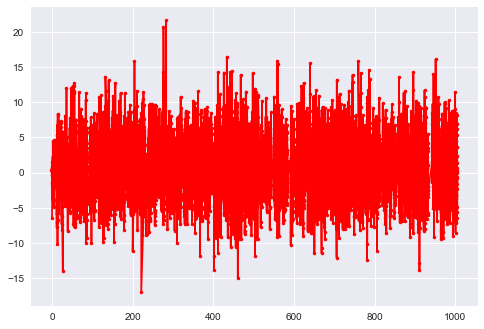

                  t             x          time
count  10001.000000  10001.000000  10001.000000
mean       0.100508      0.596079    498.823325
std        0.523739      3.785120    277.247751
min       -8.305517    -16.981569     -1.200141
25%        0.061109     -1.906369    252.243929
50%        0.096930      0.267460    489.005075
75%        0.130495      3.010145    734.063827
max       10.074134     21.594957   1005.180112
Window: 1000 to 1100


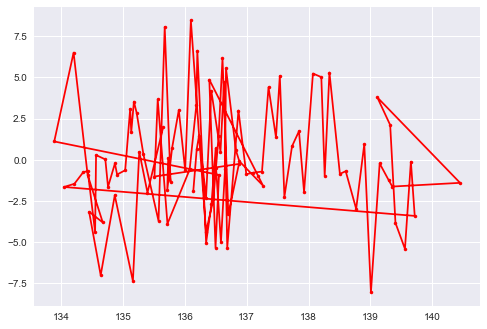

Window: 2000 to 2100


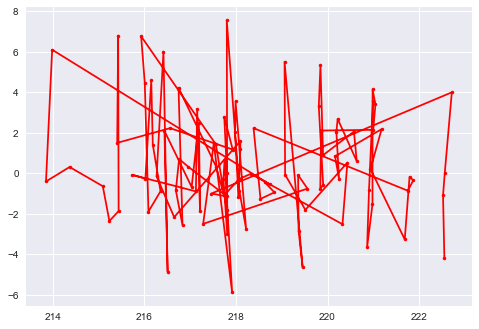

Window: 3000 to 3100


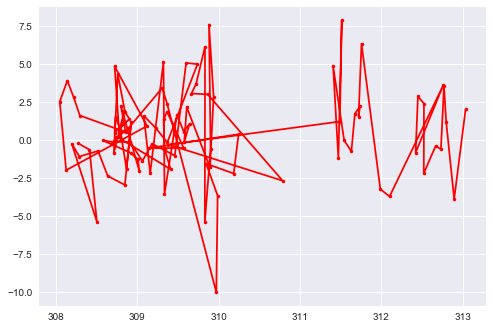

Window: 4000 to 4100


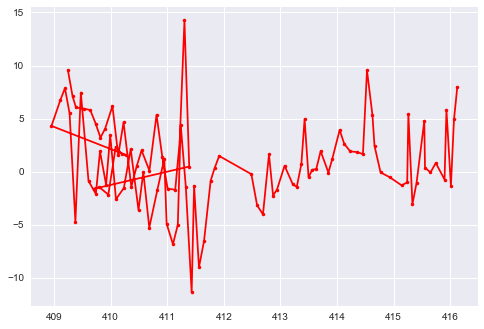

Window: 5000 to 5100


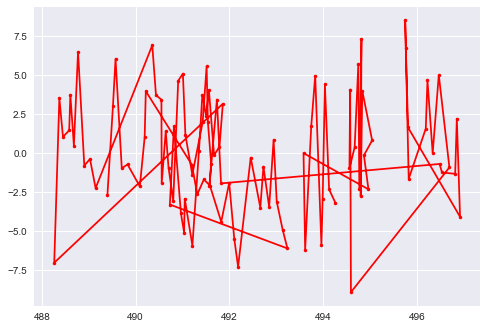

Window: 6000 to 6100


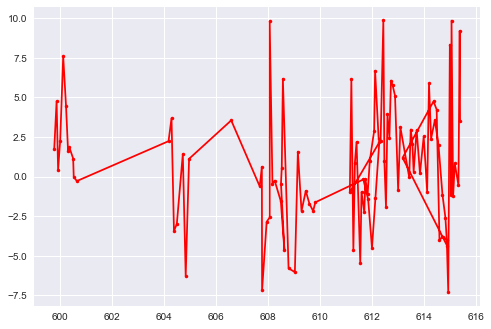

In [115]:
first_touch = x_t_log[2489]
print("Test Input:",first_touch)
with tf.Session() as sess:
    perf = net.generate_performance(first_touch,10000,sess)
print("Test Output:")
perf_df = pd.DataFrame({'t':perf.T[0], 'x':perf.T[1]})
perf_df['time'] = perf_df.t.cumsum()
#plt.show(perf_df.plot('time','x',kind='scatter'))
plt.plot(perf_df.time, perf_df.x, '.r-')
plt.show()
print(perf_df.describe())
## Investigate Output
window = 100
for n in [1000,2000,3000,4000,5000,6000]:
    print("Window:", str(n),'to',str(n+window))
    plt.plot(perf_df[n:n+window].time, perf_df[n:n+window].x, '.r-')
    plt.show()

# input_touch = first_touch.reshape([1,1,net.n_input_units]) ## Give input correct shape for one-at-a-time evaluation.
# if net.state is not None:
#     feed = {net.x: input_touch, net.init_state: net.state}
# else:
#     feed = {net.x: input_touch}
# pis, locs_1, locs_2, scales_1, scales_2, corr, net.state = sess.run([net.pis, net.locs_1, net.locs_2, net.scales_1, net.scales_2,  net.corr, net.final_state], feed_dict=feed)
# #x_1, x_2 = sketch_mixture.sample_mixture_model(pis, locs_1, locs_2, scales_1, scales_2, corr, temp=1.0, greedy=False)


## Test Training

INFO:tensorflow:Loading Training Operations
INFO:tensorflow:done initialising: musical-mdn-3layers-128units vars: 348816
Generating 50000 toy data samples.
                  t             x
count  50000.000000  50000.000000
mean       0.099998     -0.000159
std        0.007134      5.052073
min        0.000100    -10.514940
25%        0.095215     -4.828824
50%        0.099988      0.000955
75%        0.104827      4.820905
max        0.128579     10.230315
Total training examples: 49878
Done initialising loader.
INFO:tensorflow:going to train: musical-mdn-3layers-128units
INFO:tensorflow:trained batch: 100 of 498; loss was 1.650027
INFO:tensorflow:trained batch: 200 of 498; loss was 0.909253
INFO:tensorflow:trained batch: 300 of 498; loss was 0.569850
INFO:tensorflow:trained batch: 400 of 498; loss was 0.170966
INFO:tensorflow:trained epoch 0 of 1
INFO:tensorflow:saving model /tmp/tensorflow/musical-mdn-3layers-128units.ckpt.


Traceback (most recent call last):
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/logging/__init__.py", line 861, in emit
    msg = self.format(record)
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/logging/__init__.py", line 734, in format
    return fmt.format(record)
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/logging/__init__.py", line 465, in format
    record.message = record.getMessage()
  File "/usr/local/Cellar/python/2.7.13/Frameworks/Python.framework/Versions/2.7/lib/python2.7/logging/__init__.py", line 329, in getMessage
    msg = msg % self.args
TypeError: %d format: a number is required, not Variable
Logged from file <ipython-input-7-33683011ee1a>, line 146


INFO:tensorflow:saving model musical-mdn-3layers-128units.
INFO:tensorflow:took 337 to train the network


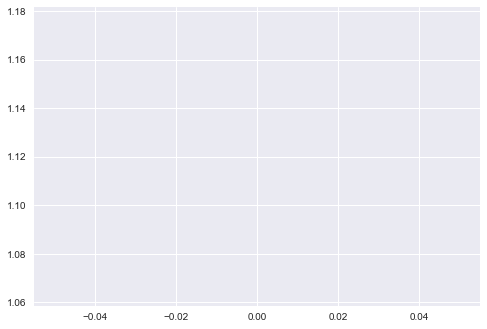

In [8]:
net = MixtureRNN()
x_t_log = musical_mdn.generate_data()
loader = musical_mdn.SequenceDataLoader(num_steps = 121,batch_size = 100, corpus = x_t_log)
losses = net.train(loader, 1, saving=True)
## Plot the losses.
plt.plot(losses)
plt.show()